![MIT Deep Learning](https://deeplearning.mit.edu/files/images/github/mit_deep_learning.png)

<table align="center">
  <td align="center"><a target="_blank" href="https://deeplearning.mit.edu">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_mit.png" style="height:40px; padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_google_colab.png" style="height:40px; padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_driving_scene_segmentation/tutorial_driving_scene_segmentation.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_github.png" style="height:40px; padding-bottom:5px;"  />View Source on GitHub</a></td>
  <td align="center"><a target="_blank" href="https://www.youtube.com/playlist?list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_youtube.png" style="height:40px; padding-bottom:5px;" />Watch Videos</a></td>
<!--   <td><a target="_blank" href="link">
        <img src="image" />text</a></td> -->
</table>

# MIT Driving Scene Segmentation

This tutorial demostrates the steps to run DeepLab semantic scene segmentation model on a sample video from MIT Driving Scene Segmentation Dataset.

In [1]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.18.0


### Build the model

**[DeepLab](https://github.com/tensorflow/models/tree/master/research/deeplab)** is a state-of-art deep learning model for semantic image segmentation, where the goal is to assign semantic labels (e.g., person, dog, cat and so on) to every pixel in the input image. Some segmentation results on Flickr images:

<p align="center">
    <img src="https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/vis1.png?raw=true" width=600></br>
    <img src="https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/vis2.png?raw=true" width=600></br>
</p>

In the driving context, we aim to obtain a semantic understanding of the front driving scene throught the camera input. This is important for driving safety and an essential requirement for all levels of autonomous driving. The first step is to build the model and load the pre-trained weights. In this demo, we use the model checkpoint trained on [Cityscapes](https://www.cityscapes-dataset.com/) dataset.

<p align="center">
    <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png" width=600></br>
    <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/zuerich00.png" width=600></br>
</p>


In [2]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [3]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [4]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
# tf.gfile.MakeDirs(model_dir) # Replaced with tf.io.gfile.makedirs
tf.io.gfile.makedirs(model_dir) # In TF 2.x, gfile functionality is under tf.io.gfile

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

AttributeError: module 'tensorflow' has no attribute 'gfile'

### Run on the sample image
The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset.

downloading the sample image...
running deeplab on the sample image...
downloading the sample image...
running deeplab on the sample image...


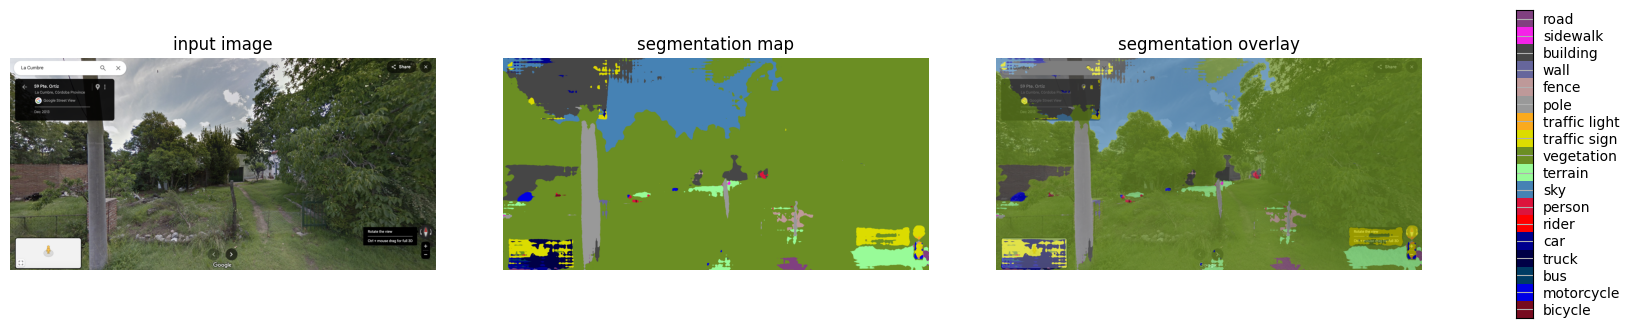

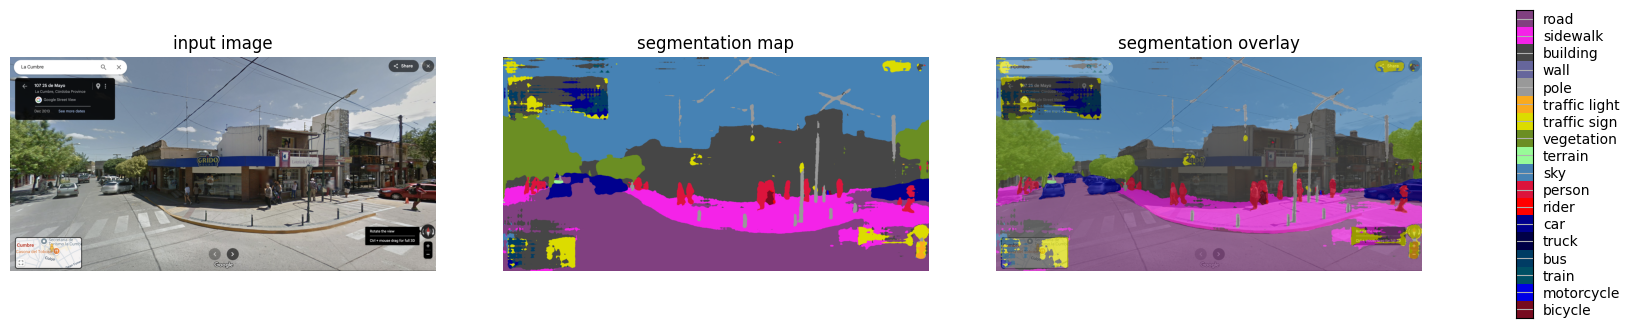

In [ ]:
SAMPLE_IMAGE = 'Ortiz North LC.png'
if not os.path.isfile(SAMPLE_IMAGE):
    print('downloading the sample image...')
    SAMPLE_IMAGE = urllib.request.urlretrieve('https://github.com/seanroulet/scene_segmentaation/raw/427fb8412046d3394d92d5ffd9fc04cb715341d0/Ortiz%20North%20LC.png')[0]
print('running deeplab on the sample image...')

SAMPLE_IMAGE2 = 'Centro North.png'
if not os.path.isfile(SAMPLE_IMAGE2):
    print('downloading the sample image...')
    SAMPLE_IMAGE2 = urllib.request.urlretrieve('https://github.com/seanroulet/scene_segmentaation/raw/427fb8412046d3394d92d5ffd9fc04cb715341d0/Centro%20North.png')[0]
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE)
run_visualization(SAMPLE_IMAGE2)



### Run on the sample video
The sample video is frame #0 to #597 in the MIT DriveSeg Dataset.

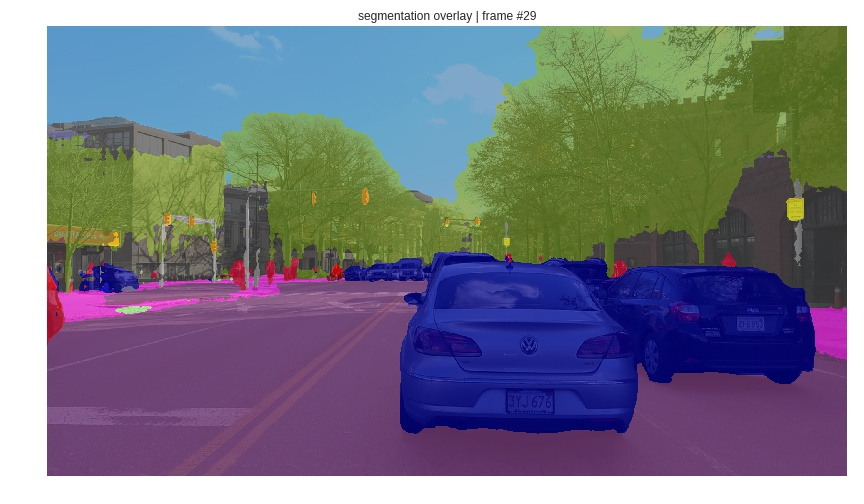

In [ ]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)


SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO):
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

### Evaluation
Now let's evaluate the model performance with the ground truth annotation. First read the annotation from a tar file.

downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


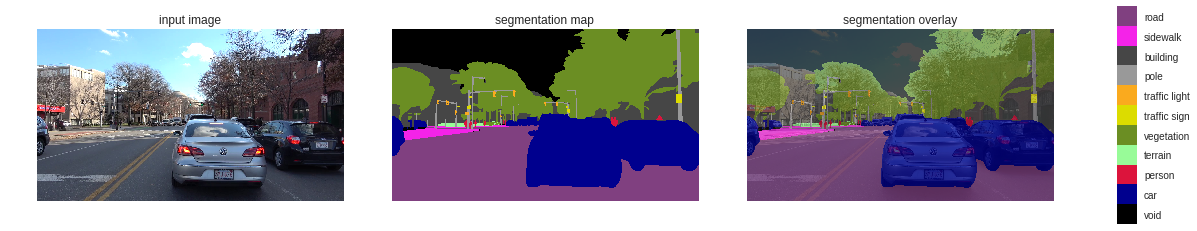

In [ ]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()

    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'
if not os.path.isfile(SAMPLE_GT):
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [ ]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)

    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19],
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703


### Evaluate on the sample video

In [ ]:
print('evaluating on the sample video...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video...


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]

pixel accuracy: 0.8995
mean class IoU: 0.5276
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4104      0.5283  0.1594           0.4487          0.5508        0.8295     0.0474    0.3879  0.9582


### Optional: leverage temporal information
One thing makes video scene segmentation different from image segmentation is the availability of previous frames, which contains valuable temporal information that may help with perception. The open question is how can we use such temporal information. Let's try conbine the prediction of two frames instead of only one frame, making smoother predictions over time.

In [ ]:
print('evaluating on the sample video with temporal smoothing...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []
prev_seg_map_logits = 0

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])

    # Get the logits instead of label prediction
    seg_map_logits = MODEL.run(original_im, OUTPUT_TENSOR_NAME='ResizeBilinear_3:0')

    # Add previous frame's logits and get the results
    seg_map = np.argmax(seg_map_logits + prev_seg_map_logits, -1)
    prev_seg_map_logits = seg_map_logits

    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video with temporal smoothing...


100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

pixel accuracy: 0.8998
mean class IoU: 0.5284
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4064      0.5285   0.158           0.4504           0.551        0.8297     0.0453    0.4008  0.9586


Can you make it better?

## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.